# METİN TESPİTİ UYGULAMASI

## Geliştirme ortamına atanan ekran kartının kontrolü

* Geliştirmeye başlamadan önce geliştirme ortamında GPU kullanımının aktifleştirildiğinden emin olunması için yukarıda "Runtime" sekmesinden "Change runtime type"a tıklayalım. Eğer GPU seçeneği seçili değilse seçim listesinden GPUyu seçelim. Bu durumda bu Python Notebook'u tekrardan yüklememiz gerekebilir.
* GPU'nun aktif olup olmadığını ve bize atanan GPU'nun özelliklerini aşağıdaki komutu çalıştırarak görebiliriz.

In [1]:
!nvidia-smi

Fri Mar  4 07:42:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Colab ile Google Drive bağlantısını kuralım

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

## Google Drive'da çalışılacak klasörün oluşturulması ve klasörün konumuna geçiş

In [ ]:
%cd /content/gdrive/MyDrive/Calisma_ortami/Bilgisayarli_Goru_Uygulama_Alanlari/Optik_Karakter_Tanima/MetinTespitiUygulaması
!mkdir TextDetection
%cd TextDetection

## Github'dan ilgili repository'nin çalışma klasörümüze yüklenmesi ve önceden eğitilmiş modellerin indirilmesi

In [ ]:
# Metin Tespiti repo'sunun kopyalanması
!git clone https://github.com/SakuraRiven/EAST.git
# Kodun bulunduğu konuma giriş
%cd EAST
# Modellerin koyulacağı klasörün oluşturulması
!mkdir pths
# Model klasörüne giriş
%cd pths
# Önceden eğitilmiş modellerin indirilmesi
file_download_link = 'https://drive.google.com/uc?export=download&id=1AFABkJgr5VtxWnmBU3XcfLJvpZkC2TAg'
!wget -O east_vgg16.pth --no-check-certificate "$file_download_link"
# Kodun bulunduğu klasöre geri dönüş
%cd %cd /content/gdrive/MyDrive/Calisma_ortami/Bilgisayarli_Goru_Uygulama_Alanlari/Optik_Karakter_Tanima/MetinTespitiUygulaması/TextDetection/EAST

## Test resimleri klasörünün çalışma alanına eklenmesi

* Size uygulama için sağlanan klasörü içindeki resim klasörünü Drive'ınızdaki Text_Detection klasörünün içine taşıyın

## Kodun çalışması için gerekli paketlerin kurulumu

In [ ]:
!pip install lanms-proper

## Resimlerdeki metinlerin tespiti ve görselleştirilmesi

In [9]:
!python detect.py

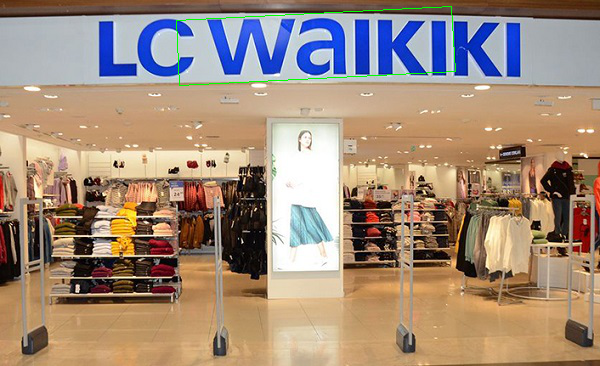

In [10]:
from IPython.display import Image as ImageDisplay
ImageDisplay('res.png')

# Metin Tespiti detaylı anlatım

In [ ]:
import PIL
import torch
# resim ve model dosyalarının konumları
resim_dosyası = '../ICDAR_2015/test_img/img_10.jpg'
model_dosyası = './pths/east_vgg16.pth'

# resmin yüklenmesi
resim = PIL.Image.open(resim_dosyası)
ImageDisplay(resim_dosyası)

In [ ]:
import detect
print("Resim En x Boy: {} x {}".format(resim.width, resim.height))
# resmin boyutlarını 32 ile bölünebilir hale getirme
# Model, resmi 5 kez yarı boyutuna küçülttüğü için resmin hem eninin, 
# hem de boyunun 32 ile bölünebilir olması gerekiyor
resim, boy_orani, en_orani = detect.resize_img(resim)
print("Resim En x Boy: {} x {}".format(resim.width, resim.height))
print(type(resim))

In [ ]:
from model import EAST
# modelin oluşturulması ve önceden eğitilmiş modelin yüklenmesi
model = EAST(pretrained=False).to("cuda:0")
model.load_state_dict(torch.load(model_dosyası))
# modelin test moduna alınması
model.eval()

# resmi modele girdi olarak verebilmek için pytorch tensörune dönüştürme
resim_tensor = detect.load_pil(resim)
print(type(resim_tensor))
print("Tensor boyutları: ")
print(resim_tensor.shape)
resim_tensor = resim_tensor.to("cuda:0")

# Modelin tahmin yapması
# skor ve geometri adında iki harita tahmin edilir
# skor haritasında 1'e yakın değerler o bölgede metin olduğunu gösterir
# geometri haritasında her bir piksel için metni boyutları ve eğimi tahmin edilir
with torch.no_grad():
    skor, geometri = model(resim_tensor)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['figure.figsize'] = (15.0, 12.0) # görselin boyutları
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def isi_haritasi_goster(resim, isi_haritasi):
    plt.figure()
    ax = plt.gca()
    im = ax.imshow(resim)

    im = ax.imshow(isi_haritasi, cmap='gray', alpha=0.5)
    ax.axis('off')
    # resmin sağ tarafında hangi rengin hangi değeri belirttiğini gösteren
    # bir gösterge oluşturur
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
print('skor objesinin boyutları:', skor.shape)
print('geometri objesinin boyutları:', geometri.shape)
print('resmin boyutları:', resim.size)
plt.imshow(skor.cpu().numpy()[0][0])
plt.show()
# NOT:  PIL Image kütüphanesi resim boyutunu önce en olacak şekilde gösterirken
# torch ve numpy önce boy olacak şekilde gösterir

In [ ]:
import cv2
skor_numpy = skor.cpu().numpy()[0][0]
# ısı haritasını resimle aynı boyuta getirme
skor_numpy = cv2.resize(skor_numpy, dsize=(1280, 704), interpolation=cv2.INTER_NEAREST)
isi_haritasi_goster(resim, skor_numpy)

## Tahmin edilen skor ve geometri haritalarından metinlerin konumlarının çıkarılması

In [ ]:
# squeeze komutu argüman olarak verilen boyutu ortadan kaldırır. Örneğin:
# geometri haritasının boyutları 1x5x176x320 iken squeeze(0) komutuyla birlikte
# 1 kaldırılarak 5x176x320 haline gelir
# get_boxes fonksiyonu model sonrası işleme ile metinlerin konumlarını
# çıkarır. Detaylar için detect.py dosyasındaki get_boxes fonksiyonunu 
# inceleyebilirsiniz
kutular = detect.get_boxes(skor.squeeze(0).cpu().numpy(), geometri.squeeze(0).cpu().numpy())
kutular = detect.adjust_ratio(kutular, en_orani, boy_orani)
print(kutular.shape)
print(kutular[:, :8])

1. boyut bulunan kutu sayısını, 2. boyut ise bulunan her bir kutunun 4 köşesinin x ve y koordinatları (4x2) ve eğim açısıdır (1) -> 4x2+1 = 9

In [ ]:
# ilk kutuyu (text box) seçelim
x1, y1, x2, y2, x3, y3, x4, y4, egim = kutular[0]
print([x1, y1, x2, y2, x3, y3, x4, y4])
plt.imshow(resim)
plt.plot((x1, x2, x3, x4, x1), (y1, y2, y3, y4, y1), marker='o', color='green', linewidth=2)
plt.show()

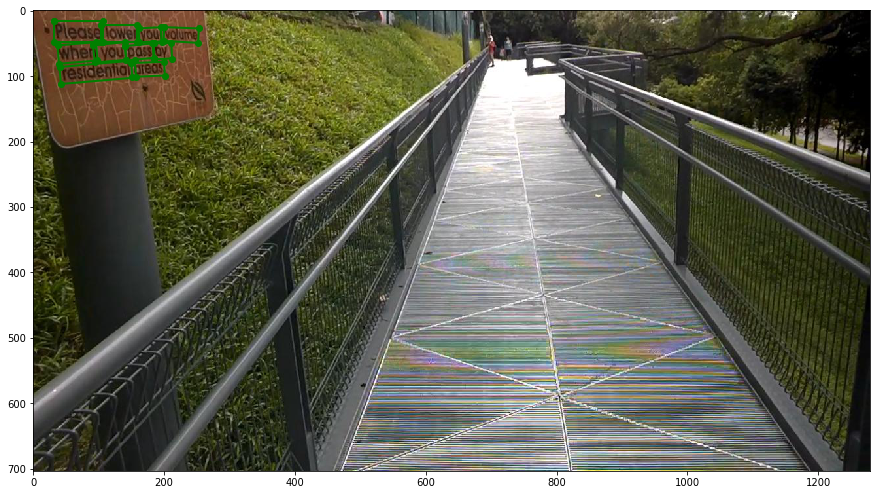

In [19]:
# tespit edilen tüm sonuçları gösterelim
for kutu in kutular:
    x1, y1, x2, y2, x3, y3, x4, y4, egim = kutu
    plt.imshow(resim)
    plt.plot((x1, x2, x3, x4, x1), (y1, y2, y3, y4, y1), marker='o', color='green', linewidth=2)
plt.show()